In [1]:
import torch
import PIL.Image
import datasets
import IPython.display
import cv2
import numpy as np
from transformers import VitMatteForImageMatting
from torchvision.transforms.v2 import ToPILImage, PILToTensor, CenterCrop

In [2]:
ds = datasets.load_dataset('timm/imagenet-1k-wds', split='validation')
model = VitMatteForImageMatting.from_pretrained("hustvl/vitmatte-small-composition-1k")

Resolving data files:   0%|          | 0/1024 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/64 [00:00<?, ?it/s]

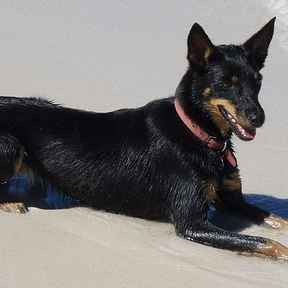

In [3]:
batch = torch.cat([PILToTensor()(CenterCrop(288)(s['jpg'].convert("RGBA"))).unsqueeze(0) for s in ds.select(range(4))])
x = batch.to(torch.float)/255 - 0.5
ToPILImage()(x[2]+0.5)

In [4]:
def otsu(batch_images):
    batch, _, h, w = batch_images.shape
    thresholded_images = torch.zeros_like(batch_images)
    for i in range(batch):
        img = batch_images[i, 0].cpu().numpy()  # Convert to NumPy
        img = (img * 255).astype(np.uint8)  # Convert to 8-bit format
        _, binary_img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        thresholded_images[i, 0] = torch.tensor(binary_img / 255.0, dtype=batch_images.dtype)
    return thresholded_images

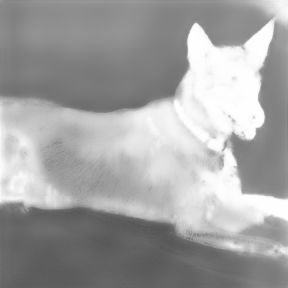

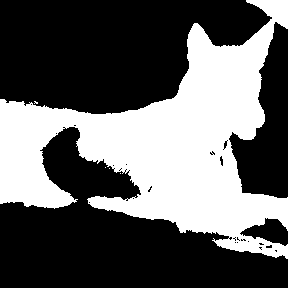

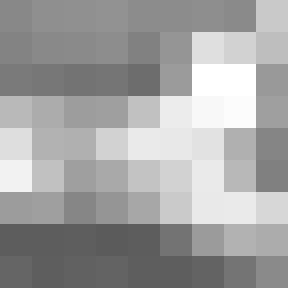

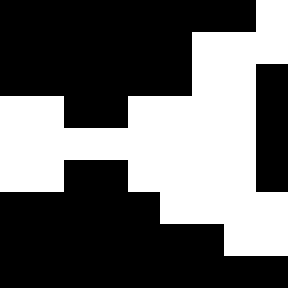

In [5]:
with torch.no_grad():
    y = model(x).alphas
y2 = torch.cat([PILToTensor()(ToPILImage()(yi).resize((9,9),resample=PIL.Image.Resampling.LANCZOS)).unsqueeze(0) for yi in y]).to(torch.float)/255
b = otsu(y)
b2 = otsu(y2)
display(ToPILImage()(y[2]))
display(ToPILImage()(b[2]))
display(ToPILImage()(y2[2]).resize((288,288),resample=PIL.Image.Resampling.NEAREST))
display(ToPILImage()(b2[2].to(torch.float)).resize((288,288),resample=PIL.Image.Resampling.NEAREST))

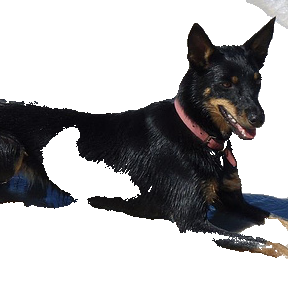

In [21]:
x[:,3,:,:] = b[:,0,:,:]-0.5
ToPILImage()(x[2]+0.5)